In [16]:
import sys

from pathlib import Path
project_root = Path.cwd().parent.parent
sys.path.append(str(project_root))
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from src.data_management.data_preprocessing_pipeline import DataPreprocessingPipeline
from sklearn.metrics import mean_absolute_error, r2_score
from lightgbm import LGBMRegressor


# Loading dataset
path = "/Users/Macbook/Desktop/emergency-dept-optimization"
emergency_df = pd.read_sas(f"{path}/nhamcs14.sas7bdat")
target = "LOV"

        
# Instantiate the data preprocessing pipeline
pipeline = DataPreprocessingPipeline(emergency_df=emergency_df,target=target,percent_train=0.7,percent_val=0.15,percent_test=0.15,path=path,stratify=False)

# Run the pipeline
pipeline.run()

X_train = pipeline.X_train
X_validation = pipeline.X_validation
X_test = pipeline.X_test

y_train = pipeline.y_train
y_validation = pipeline.y_validation
y_test = pipeline.y_test

X_train_preprocessed = pipeline.X_train_preprocessed
X_validation_preprocessed = pipeline.X_validation_preprocessed
X_test_preprocessed = pipeline.X_test_preprocessed



 
Cleaning data...
Some columns have missing values:
Initial emergency dataset: (23844, 1012)
Cleaned emergency dataset: (22308, 870)
Splitting data...
Sizes of the split datasets:
train_df: (15615, 870)
test_df: (3346, 870)
validation_df: (3347, 870)
train_df has been saved with success
test_df has been saved with success
validation_df has been saved with success
Loading data...
train_df size: (15615, 870)
X_train size: (15615, 869)
y_train size: (15615,)

validation_df size: (3347, 870)
X_validation size: (3347, 869)
y_validation size: (3347,)

test_df size: (3346, 870)
X_test size: (3346, 869)
y_test size: (3346,)
Transforming data...
Data preprocessing pipeline completed.
 


### Looking at the distribution of the length of visits (LOV) both with and without outliers

Text(0.5, 1.0, 'Length of Visits  Distribution with outliers')

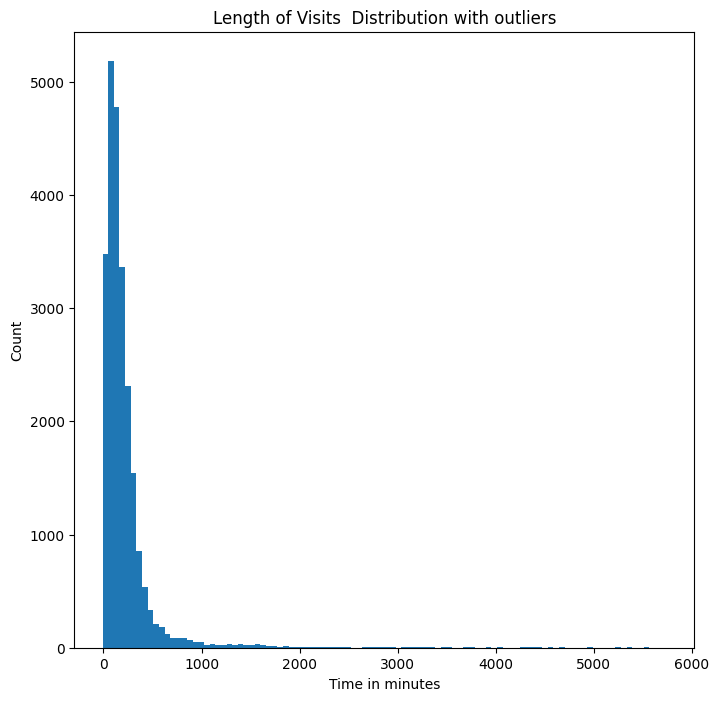

In [17]:
from IPython.core.pylabtools import figsize
figsize(8, 8)
plt.hist(emergency_df[target].dropna(), bins = 100)
plt.xlabel('Time in minutes')
plt.ylabel('Count')
plt.title('Length of Visits  Distribution with outliers')

Text(0.5, 1.0, 'Length of Visits  Distribution without outliers')

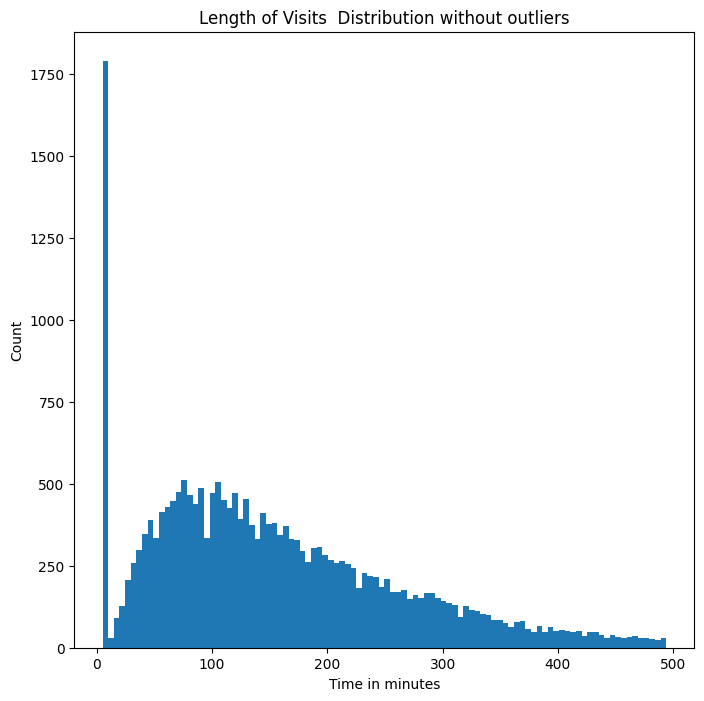

In [18]:
from IPython.core.pylabtools import figsize
figsize(8, 8)
plt.hist(pipeline.cleaned_emmergency_df[target_column].dropna(), bins = 100)
plt.xlabel('Time in minutes')
plt.ylabel('Count')
plt.title('Length of Visits  Distribution without outliers')
#plt.title('WAITTIME  Distribution with outliers')

## Take away

##### * The first histogram shows a highly skewed distribution with a long tail, which indicates the presence of outliers.
 #### * The most common length of visit is very short, with a LOV of 9 having the highest frequency (1772 counts).
 #### * There are instances where LOV is extremely high, which are rare (as indicated by counts of 1) and are likely outliers.


 #### * The second histogram shows the distribution after outliers have been removed. The x-axis scale is much reduced, going up to 500, which indicates that extreme values have been excluded.

 #### * This distribution is more representative of the typical length of visits, showing a peak and a more bell-shaped curve, though it is still right-skewed.

#### * The most common LOV remains the same, with a peak at a length of 9, but the overall frequency counts are slightly lower, which suggests that some of the counts in the outlier data might have been due to these extreme values.

#### * The processed data without outliers shows that the most frequent visits are very short, with a sharp drop-off as visit length increases.

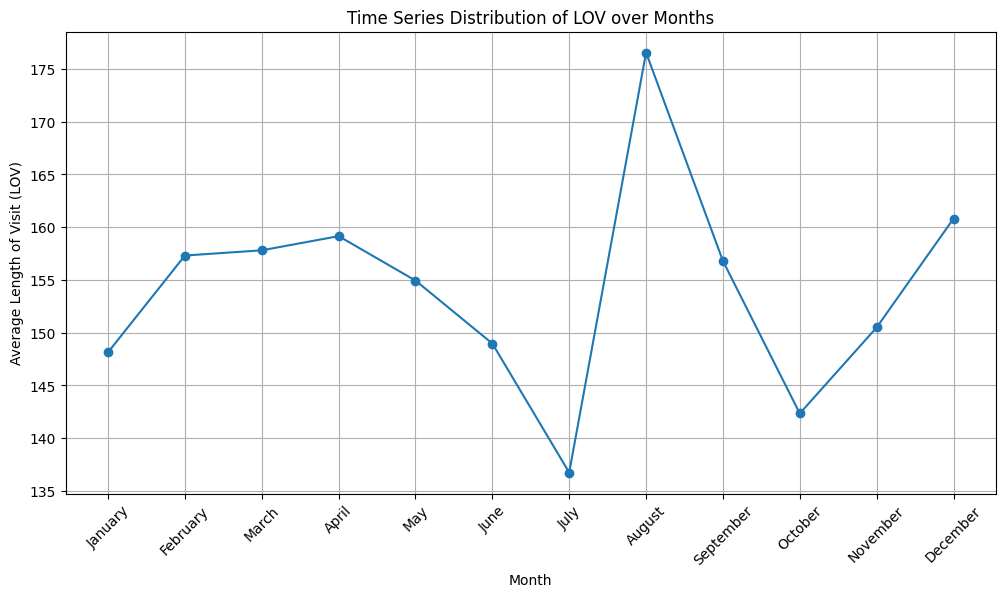

In [19]:
# dictionary to map month numbers to month names
month_map = {1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May', 6: 'June',
             7: 'July', 8: 'August', 9: 'September', 10: 'October', 11: 'November', 12: 'December'}

# Convert 'VMONTH' column to month names
pipeline.train_df['VMONTH_NAME'] = pipeline.train_df['VMONTH'].map(month_map)

# Group by 'VMONTH_NAME' and calculate the mean 'LOV' for each month
monthly_lov = pipeline.train_df.groupby('VMONTH_NAME')['LOV'].mean().reset_index()

# Sort the data by month order
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']
monthly_lov['VMONTH_NAME'] = pd.Categorical(monthly_lov['VMONTH_NAME'], categories=month_order, ordered=True)
monthly_lov = monthly_lov.sort_values('VMONTH_NAME')

# Create a line chart
plt.figure(figsize=(12, 6))
plt.plot(monthly_lov['VMONTH_NAME'], monthly_lov['LOV'], marker='o')
plt.xlabel('Month')
plt.ylabel('Average Length of Visit (LOV)')
plt.title('Time Series Distribution of LOV over Months')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [21]:
import joblib
import os
# Create an instance of the LGBMRegressor with the best hyperparameters
final_model = LGBMRegressor(
    random_state=42,
    force_col_wise=True,
    verbosity=-1,
    subsample=0.8,
    num_leaves=255,
    n_estimators=1000,
    min_child_samples=20,
    max_depth=11,
    learning_rate=0.01,
    colsample_bytree=0.6
)
# Set up the path to the model file
model_train_dir = "/Users/Macbook/Desktop/emergency-dept-optimization/src/model_training/model_train"  # Absolute path to the model directory
model_filename = "LGBMRegressor_tuned.pkl"  # The filename of the saved model
model_file_path = os.path.join(model_train_dir, model_filename)

# Check if the model file exists before trying to load it
if os.path.exists(model_file_path):
    trained_model = joblib.load(model_file_path)
    print("Model loaded successfully.")
else:
    print(f"No such file found: {model_file_path}")

# Make predictions on the test dataset
y_pred_test = trained_model.predict(X_test_preprocessed)

# Evaluate the final model's performance on the test dataset
mae_test = mean_absolute_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

print("Test Set Performance:")
print("MAE:", mae_test)
print("R-squared:", r2_test)


Model loaded successfully.
Test Set Performance:
MAE: 48.384369340845694
R-squared: 0.6171066029969638


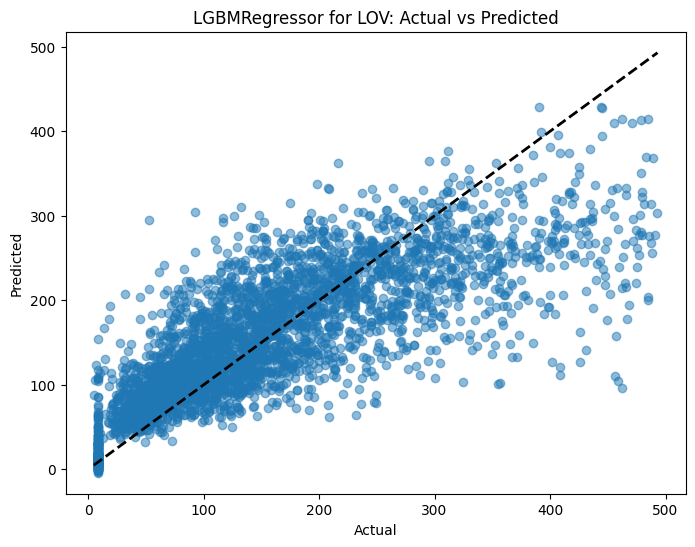

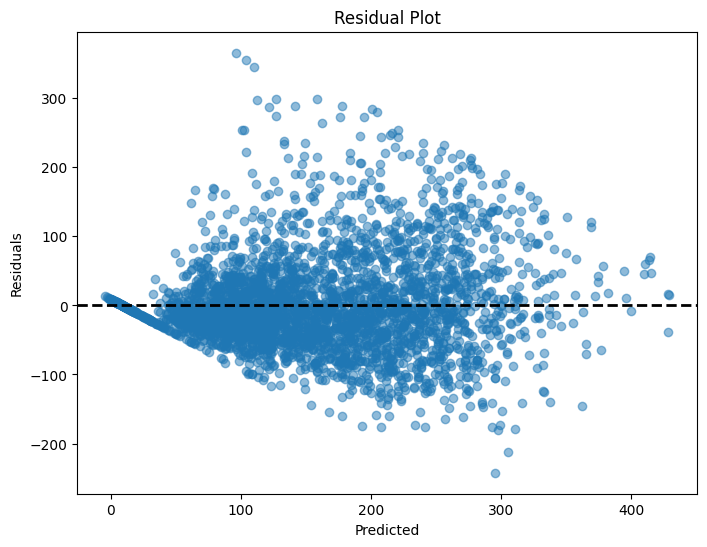

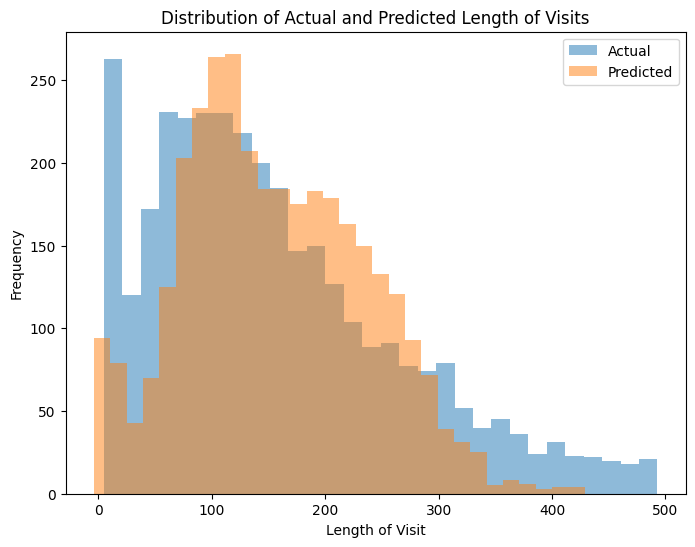

In [22]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_test, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('LGBMRegressor for LOV: Actual vs Predicted')
plt.show()

residuals = y_test - y_pred_test
plt.figure(figsize=(8, 6))
plt.scatter(y_pred_test, residuals, alpha=0.5)
plt.axhline(y=0, color='k', linestyle='--', lw=2)
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

plt.figure(figsize=(8, 6))
plt.hist(y_test, bins=30, alpha=0.5, label='Actual')
plt.hist(y_pred_test, bins=30, alpha=0.5, label='Predicted')
plt.xlabel('Length of Visit')
plt.ylabel('Frequency')
plt.title('Distribution of Actual and Predicted Length of Visits')
plt.legend()
plt.show()